# Fit a volume via raymarching

The tutorial teaches how to reconstruct a 3D volume (like a foggy 3D shape made of tiny cubes called voxels) from a bunch of 2D images taken from different viewpoints. To do this, we use a technique called differentiable volumetric rendering, where the computer "learns" what the 3D volume must look like to match the 2D images it's given. This process is done using a method called raymarching.

We begin with:

- A pre-existing 3D mesh of a cow (like a digital sculpture).

- A function that renders this cow from multiple angles to generate synthetic 2D images and their silhouettes (outlines).

- We treat these images as our training data, pretending that we don’t know what the 3D cow looks like.

Raymarching is a method of rendering where you imagine shooting a ray (a straight line) from each pixel of an image into the 3D world. As the ray moves forward, it samples data from points in 3D space (specifically, the volume made of voxels). At each point, we ask: "Is there something here? What color and opacity is it?" The ray keeps going, collecting data, and in the end, we blend all those samples into a final pixel color and transparency.

Think of it like shining a flashlight through fog and watching how much light gets through based on how thick the fog is.

## How is it Done
1. Create training images:
We render the 3D cow from 40 different angles. Each rendered image is paired with a silhouette and the camera setup (where the camera was and how it was pointing).
2. Set up the volumetric renderer, This involves two parts:
- Raysampler: Shoots rays from each pixel and chooses where along the ray to sample points.
- Raymarcher: Takes the samples (color and opacity) and blends them into a final pixel output.
3. Build the volume model. We define a 3D grid (volume) where each cell (voxel) has:
- A color (RGB).
- A density (opacity or fogginess).
- Initially, the volume is just gray and almost fully transparent. We store color and density in a log space to keep them between 0 and 1.
4. Train the model. We render the current guess of the volume using the same camera views as the original images, and compare:
- The rendered images vs. the target images.
- The rendered silhouettes vs. the target silhouettes.
- The model adjusts its color and density values to make the rendered views look more like the real ones. This is done using gradient descent (a way for the model to "learn" through trial and error).
5. Repeat and improve:
We do this over 300 steps (iterations), improving the volume each time. Every now and then, we reduce the learning rate to fine-tune the result. We also visualize how well our volume is matching the images during training.

More specifically, this tutorial will explain how to:
1. Create a differentiable volumetric renderer.
2. Create a Volumetric model (including how to use the `Volumes` class).
3. Fit the volume based on the images using the differentiable volumetric renderer.
4. Visualize the predicted volume.

## 0. Install and Import modules
Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-syeq9za1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-syeq9za1
  Running command git checkout -q 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.8-cp311-cp311-linux_x86_64.whl size=60242290 sha256=e0ea1651de38ed1e3387d6d27ed7ae41dac73be25574c8dfa973df770c246ee8
  Stored in directory: /tmp/pip-ephem-wheel-cache-1hs09nws/wheels/08/90/1b/df18c3e3634f86278e793b87f37ea4c58d0c36731196122518
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=d12428abd715ad919934be3

In [2]:
import os
import sys
import time
import json
import glob
import torch
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython import display

# Data structures and functions for rendering
from pytorch3d.structures import Volumes
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    VolumeRenderer,
    NDCMultinomialRaysampler,
    EmissionAbsorptionRaymarcher
)
from pytorch3d.transforms import so3_exp_map

# obtain the utilized device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [20]:
import os

import numpy as np
import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    BlendParams,
    FoVPerspectiveCameras,
    look_at_view_transform,
    MeshRasterizer,
    MeshRenderer,
    PointLights,
    RasterizationSettings,
    SoftPhongShader,
    SoftSilhouetteShader,
)


def generate_bush_renders(
    num_views: int = 40, azimuth_range: float = 180
):
    """
    This function generates `num_views` renders of a cow mesh.
    The renders are generated from viewpoints sampled at uniformly distributed
    azimuth intervals. The elevation is kept constant so that the camera's
    vertical position coincides with the equator.

    For a more detailed explanation of this code, please refer to the
    docs/tutorials/fit_textured_mesh.ipynb notebook.

    Args:
        num_views: The number of generated renders.
        azimuth_range: number of degrees on each side of the start position to
            take samples

    Returns:
        cameras: A batch of `num_views` `FoVPerspectiveCameras` from which the
            images are rendered.
        images: A tensor of shape `(num_views, height, width, 3)` containing
            the rendered images.
        silhouettes: A tensor of shape `(num_views, height, width)` containing
            the rendered silhouettes.
    """

    # Setup
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cpu")

    # Load obj file
    obj_filename = "blueberry_bush_cutout.obj"
    mesh = load_objs_as_meshes([obj_filename], device=device)

    # We scale normalize and center the target mesh to fit in a sphere of radius 1
    # centered at (0,0,0). (scale, center) will be used to bring the predicted mesh
    # to its original center and scale.  Note that normalizing the target mesh,
    # speeds up the optimization but is not necessary!
    verts = mesh.verts_packed()
    N = verts.shape[0]
    center = verts.mean(0)
    scale = max((verts - center).abs().max(0)[0])
    mesh.offset_verts_(-(center.expand(N, 3)))
    mesh.scale_verts_((1.0 / float(scale)))

    # Get a batch of viewing angles.
    elev = torch.linspace(0, 0, num_views)  # keep constant
    azim = torch.linspace(-azimuth_range, azimuth_range, num_views) + 180.0

    # Place a point light in front of the object. As mentioned above, the front of
    # the cow is facing the -z direction.
    lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

    # Initialize an OpenGL perspective camera that represents a batch of different
    # viewing angles. All the cameras helper methods support mixed type inputs and
    # broadcasting. So we can view the camera from the a distance of dist=2.7, and
    # then specify elevation and azimuth angles for each viewpoint as tensors.
    R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    # Define the settings for rasterization and shading. Here we set the output
    # image to be of size 128X128. As we are rendering images for visualization
    # purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to
    # rasterize_meshes.py for explanations of these parameters.  We also leave
    # bin_size and max_faces_per_bin to their default values of None, which sets
    # their values using heuristics and ensures that the faster coarse-to-fine
    # rasterization method is used.  Refer to docs/notes/renderer.md for an
    # explanation of the difference between naive and coarse-to-fine rasterization.
    raster_settings = RasterizationSettings(
        image_size=128, blur_radius=0.0, faces_per_pixel=1
    )

    # Create a Phong renderer by composing a rasterizer and a shader. The textured
    # Phong shader will interpolate the texture uv coordinates for each vertex,
    # sample from a texture image and apply the Phong lighting model
    blend_params = BlendParams(sigma=1e-4, gamma=1e-4, background_color=(0.0, 0.0, 0.0))
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
        shader=SoftPhongShader(
            device=device, cameras=cameras, lights=lights, blend_params=blend_params
        ),
    )

    # Create a batch of meshes by repeating the cow mesh and associated textures.
    # Meshes has a useful `extend` method which allows us do this very easily.
    # This also extends the textures.
    meshes = mesh.extend(num_views)

    # Render the cow mesh from each viewing angle
    target_images = renderer(meshes, cameras=cameras, lights=lights)

    # Rasterization settings for silhouette rendering
    sigma = 1e-4
    raster_settings_silhouette = RasterizationSettings(
        image_size=128, blur_radius=np.log(1.0 / 1e-4 - 1.0) * sigma, faces_per_pixel=50
    )

    # Silhouette renderer
    renderer_silhouette = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, raster_settings=raster_settings_silhouette
        ),
        shader=SoftSilhouetteShader(),
    )

    # Render silhouette images.  The 3rd channel of the rendering output is
    # the alpha/silhouette channel
    silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)

    # binary silhouettes
    silhouette_binary = (silhouette_images[..., 3] > 1e-4).float()

    return cameras, target_images[..., :3], silhouette_binary

In [3]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
from plot_image_grid import image_grid
from generate_cow_renders import generate_cow_renders

--2025-05-11 15:41:02--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2025-05-11 15:41:03 (4.25 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]

--2025-05-11 15:41:03--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request se

## 1. Generate images of the scene and masks

The following cell generates our training data.
It renders the cow mesh from the `fit_textured_mesh.ipynb` tutorial from several viewpoints and returns:
1. A batch of image and silhouette tensors that are produced by the cow mesh renderer.
2. A set of cameras corresponding to each render.

Note: For the purpose of this tutorial, which aims at explaining the details of volumetric rendering, we do not explain how the mesh rendering, implemented in the `generate_cow_renders` function, works. Please refer to `fit_textured_mesh.ipynb` for a detailed explanation of mesh rendering.

In [23]:
target_cameras, target_images, target_silhouettes = generate_cow_renders(num_views=40)
print(f'Generated {len(target_images)} images/silhouettes/cameras.')

Generated 40 images/silhouettes/cameras.


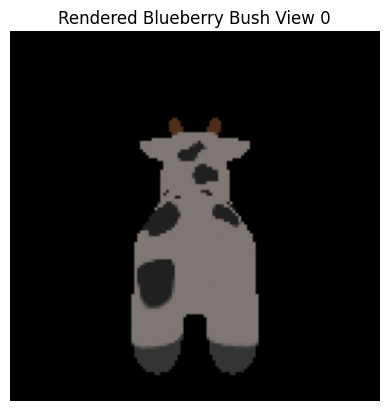

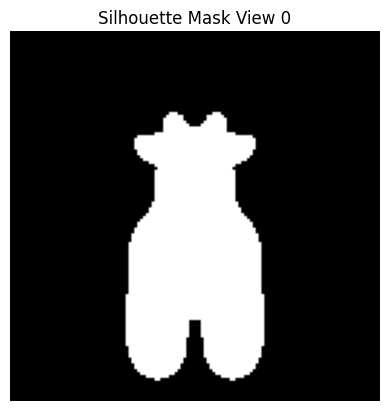

In [24]:
plt.imshow(target_images[0].cpu().numpy())
plt.title("Rendered View 0")
plt.axis("off")
plt.show()

# View the corresponding silhouette
plt.imshow(target_silhouettes[0].cpu().numpy(), cmap='gray')
plt.title("Silhouette Mask View 0")
plt.axis("off")
plt.show()

## 2. Initialize the volumetric renderer

This part sets up the volumetric renderer, a tool that allows us to simulate how light would travel through a 3D volume to form a 2D image. The core idea is: from each pixel, we shoot a ray into the 3D scene and collect information about color and transparency at regular intervals (samples).

1. Raysampler – defines where to shoot rays and where to sample points along each ray.

2. Raymarcher – uses those samples to compute a final pixel color by blending the contributions along the ray.

The following initializes a volumetric renderer that emits a ray from each pixel of a target image and samples a set of uniformly-spaced points along the ray. At each ray-point, the corresponding density and color value is obtained by querying the corresponding location in the volumetric model of the scene (the model is described & instantiated in a later cell).

The renderer is composed of a *raymarcher* and a *raysampler*.
- The *raysampler* is responsible for emitting rays from image pixels and sampling the points along them. Here, we use the `NDCMultinomialRaysampler` which follows the standard PyTorch3D coordinate grid convention (+X from right to left; +Y from bottom to top; +Z away from the user).
- The *raymarcher* takes the densities and colors sampled along each ray and renders each ray into a color and an opacity value of the ray's source pixel. Here we use the `EmissionAbsorptionRaymarcher` which implements the standard Emission-Absorption raymarching algorithm.

In [6]:
# render_size describes the size of both sides of the
# rendered images in pixels. We set this to the same size
# as the target images. I.e. we render at the same
# size as the ground truth images.
render_size = target_images.shape[1]

# Our rendered scene is centered around (0,0,0)
# and is enclosed inside a bounding box
# whose side is roughly equal to 3.0 (world units).
volume_extent_world = 3.0

# 1) Instantiate the raysampler.
# Here, NDCMultinomialRaysampler generates a rectangular image
# grid of rays whose coordinates follow the PyTorch3D
# coordinate conventions.
# Since we use a volume of size 128^3, we sample n_pts_per_ray=150,
# which roughly corresponds to a one ray-point per voxel.
# We further set the min_depth=0.1 since there is no surface within
# 0.1 units of any camera plane.
raysampler = NDCMultinomialRaysampler(
    image_width=render_size,
    image_height=render_size,
    n_pts_per_ray=150,
    min_depth=0.1,
    max_depth=volume_extent_world,
)


# 2) Instantiate the raymarcher.
# Here, we use the standard EmissionAbsorptionRaymarcher
# which marches along each ray in order to render
# each ray into a single 3D color vector
# and an opacity scalar.
raymarcher = EmissionAbsorptionRaymarcher()

# Finally, instantiate the volumetric render
# with the raysampler and raymarcher objects.
renderer = VolumeRenderer(
    raysampler=raysampler, raymarcher=raymarcher,
)

## 3. Initialize the volumetric model

We define a class called VolumeModel which represents this 3D foggy volume. The volume is made of tiny cubes (voxels) arranged in a 3D grid. Each voxel holds a color (RGB) and a density (how opaque it is). Since color and density should always stay between 0 and 1, we store them in a different format: in something called log-space, which means we start with arbitrary values (like 0 or -4) and later pass them through a sigmoid function. Sigmoid is just a squashing function — it takes any number and converts it to a value between 0 and 1, which is perfect for things like color intensity and opacity.

At the beginning, all colors are set to zero in log-space, so after sigmoid, they come out as 0.5 — which is a neutral gray. All densities are set to -4, which after sigmoid gives a low number (around 0.018) — so very faint, almost fully transparent fog.

The forward() function is where the rendering happens. It takes in a batch of cameras (viewpoints), prepares a batch of volumes (copying the same fog volume for each camera), and sends it through the renderer to generate 2D images.

Additionally, `VolumeModel` contains the renderer object. This object stays unaltered throughout the optimization.

Then there’s the huber() function. This is a special type of error function that measures how far off our predicted image is from the real one. It’s called “smooth L1” because it behaves like squared error for small differences and like absolute error for big ones. This makes it stable and less sensitive to outliers. We’ll use this to compare our current rendered image to the target one and tell the model how to improve.

In [7]:
class VolumeModel(torch.nn.Module):
    def __init__(self, renderer, volume_size=[64] * 3, voxel_size=0.1):
        super().__init__()
        # After evaluating torch.sigmoid(self.log_colors), we get
        # densities close to zero.
        self.log_densities = torch.nn.Parameter(-4.0 * torch.ones(1, *volume_size))
        # After evaluating torch.sigmoid(self.log_colors), we get
        # a neutral gray color everywhere.
        self.log_colors = torch.nn.Parameter(torch.zeros(3, *volume_size))
        self._voxel_size = voxel_size
        # Store the renderer module as well.
        self._renderer = renderer

    def forward(self, cameras):
        batch_size = cameras.R.shape[0]

        # Convert the log-space values to the densities/colors
        densities = torch.sigmoid(self.log_densities)
        colors = torch.sigmoid(self.log_colors)

        # Instantiate the Volumes object, making sure
        # the densities and colors are correctly
        # expanded batch_size-times.
        volumes = Volumes(
            densities = densities[None].expand(
                batch_size, *self.log_densities.shape),
            features = colors[None].expand(
                batch_size, *self.log_colors.shape),
            voxel_size=self._voxel_size,
        )

        # Given cameras and volumes, run the renderer
        # and return only the first output value
        # (the 2nd output is a representation of the sampled
        # rays which can be omitted for our purpose).
        return self._renderer(cameras=cameras, volumes=volumes)[0]

# A helper function for evaluating the smooth L1 (huber) loss
# between the rendered silhouettes and colors.
def huber(x, y, scaling=0.1):
    diff_sq = (x - y) ** 2
    loss = ((1 + diff_sq / (scaling**2)).clamp(1e-4).sqrt() - 1) * float(scaling)
    return loss

## 4. Fit the volume

Here we carry out the volume fitting with differentiable rendering.

In order to fit the volume, we render it from the viewpoints of the `target_cameras`
and compare the resulting renders with the observed `target_images` and `target_silhouettes`.

The comparison is done by evaluating the mean huber (smooth-l1) error between corresponding
pairs of `target_images`/`rendered_images` and `target_silhouettes`/`rendered_silhouettes`.

We start by creating our volume model. This model represents the 3D space as a grid of small cubes (voxels), each with a color and density (opacity). We set the grid size to 128×128×128 voxels. We also tell it how big each voxel should be in real-world units by dividing the scene size (3 units) by 128.

Next, we set up an optimizer, specifically Adam, which is an algorithm that knows how to adjust the parameters of the model to reduce the error. The learning rate is 0.1, which controls how big the adjustments are at each step. Too big and we might overshoot the goal; too small and learning becomes slow.

We tell the model to do 300 learning steps. In each step, we’ll take a random sample of 10 images out of the 40. This is called a minibatch — it helps the model generalize better and train faster than using all images at once.

Every step begins by resetting gradients to zero. Gradients are the direction and strength of the change needed to improve the model.

Then, we randomly choose 10 camera positions. For each one, we re-create the camera object with its rotation, translation, and view parameters (field of view, near and far clipping planes, aspect ratio). This tells the renderer where each virtual camera is and where it’s looking.

We render the current state of our volume from these cameras. The result is two outputs:
- a rendered image (with RGB colors),
- a rendered silhouette (a mask showing where the object is visible).

Now we compare the model’s prediction to the real data. We use the huber loss function to compare:

1. The model’s image vs. the actual image.
2. The model’s mask vs. the actual silhouette.

Huber loss gives a score — lower means better. We add both errors together to form the total loss value. This number tells us how wrong the current model is.

Every 10 steps, we print out the color and silhouette errors so we can track progress. Every 40 steps, we also show a visual comparison between the rendered and actual images and masks — this helps us see if the volume is starting to look like the object in the photos.

Finally, the key step: we call loss.backward() to calculate how each voxel’s color and density need to change to improve the result. Then optimizer.step() updates the model using those gradients.

After 300 iterations, the volume will have changed from foggy gray blobs into something that looks like the original object, seen from all angles.

In [11]:
# First move all relevant variables to the correct device.
target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouettes = target_silhouettes.to(device)

# Instantiate the volumetric model.
# We use a cubical volume with the size of
# one side = 128. The size of each voxel of the volume
# is set to volume_extent_world / volume_size s.t. the
# volume represents the space enclosed in a 3D bounding box
# centered at (0, 0, 0) with the size of each side equal to 3.
volume_size = 128
volume_model = VolumeModel(
    renderer,
    volume_size=[volume_size] * 3,
    voxel_size = volume_extent_world / volume_size,
).to(device)

# Instantiate the Adam optimizer. We set its master learning rate to 0.1.
lr = 0.1
optimizer = torch.optim.Adam(volume_model.parameters(), lr=lr)

# We do 300 Adam iterations and sample 10 random images in each minibatch.
batch_size = 10
n_iter = 300

color_loss_history = []
silhouette_loss_history = []

for iteration in range(n_iter):

    # In case we reached the last 75% of iterations,
    # decrease the learning rate of the optimizer 10-fold.
    if iteration == round(n_iter * 0.75):
        print('Decreasing LR 10-fold ...')
        optimizer = torch.optim.Adam(
            volume_model.parameters(), lr=lr * 0.1
        )

    # Zero the optimizer gradient.
    optimizer.zero_grad()

    # Sample random batch indices.
    batch_idx = torch.randperm(len(target_cameras))[:batch_size]

    # Sample the minibatch of cameras.
    batch_cameras = FoVPerspectiveCameras(
        R = target_cameras.R[batch_idx],
        T = target_cameras.T[batch_idx],
        znear = target_cameras.znear[batch_idx],
        zfar = target_cameras.zfar[batch_idx],
        aspect_ratio = target_cameras.aspect_ratio[batch_idx],
        fov = target_cameras.fov[batch_idx],
        device = device,
    )

    # Evaluate the volumetric model.
    rendered_images, rendered_silhouettes = volume_model(
        batch_cameras
    ).split([3, 1], dim=-1)

    # Compute the silhouette error as the mean huber
    # loss between the predicted masks and the
    # target silhouettes.
    sil_err = huber(
        rendered_silhouettes[..., 0], target_silhouettes[batch_idx],
    ).abs().mean()

    # Compute the color error as the mean huber
    # loss between the rendered colors and the
    # target ground truth images.
    color_err = huber(
        rendered_images, target_images[batch_idx],
    ).abs().mean()


    # The optimization loss is a simple
    # sum of the color and silhouette errors.
    loss = color_err + sil_err

    color_loss_history.append(color_err.item())
    silhouette_loss_history.append(sil_err.item())

    # Print the current values of the losses.
    if iteration % 10 == 0:
        print(
            f'Iteration {iteration:05d}:'
            + f' color_err = {float(color_err):1.2e}'
            + f' mask_err = {float(sil_err):1.2e}'
        )

    # Take the optimization step.
    loss.backward()
    optimizer.step()

    # Visualize the renders every 20 iterations.
    if iteration % 10 == 0:
        # Visualize only a single randomly selected element of the batch.
        im_show_idx = int(torch.randint(low=0, high=batch_size, size=(1,)))
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        ax = ax.ravel()
        clamp_and_detach = lambda x: x.clamp(0.0, 1.0).cpu().detach().numpy()
        ax[0].imshow(clamp_and_detach(rendered_images[im_show_idx]))
        ax[1].imshow(clamp_and_detach(target_images[batch_idx[im_show_idx], ..., :3]))
        ax[2].imshow(clamp_and_detach(rendered_silhouettes[im_show_idx, ..., 0]))
        ax[3].imshow(clamp_and_detach(target_silhouettes[batch_idx[im_show_idx]]))
        for ax_, title_ in zip(
            ax,
            ("rendered image", "target image", "rendered silhouette", "target silhouette")
        ):
            ax_.grid("off")
            ax_.axis("off")
            ax_.set_title(title_)
        fig.canvas.draw(); fig.show()
        display.clear_output(wait=True)
        display.display(fig)

Output hidden; open in https://colab.research.google.com to view.

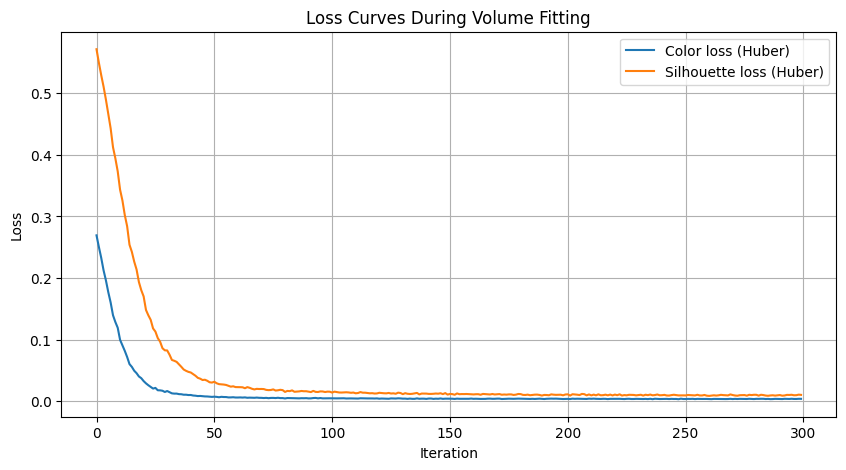

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(color_loss_history, label="Color loss (Huber)")
plt.plot(silhouette_loss_history, label="Silhouette loss (Huber)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curves During Volume Fitting")
plt.legend()
plt.grid(True)
plt.show()

## 5. Visualizing the optimized volume

Finally, we visualize the optimized volume by rendering from multiple viewpoints that rotate around the volume's y-axis.

Generating rotating volume ...


  0%|          | 0/28 [00:00<?, ?it/s]

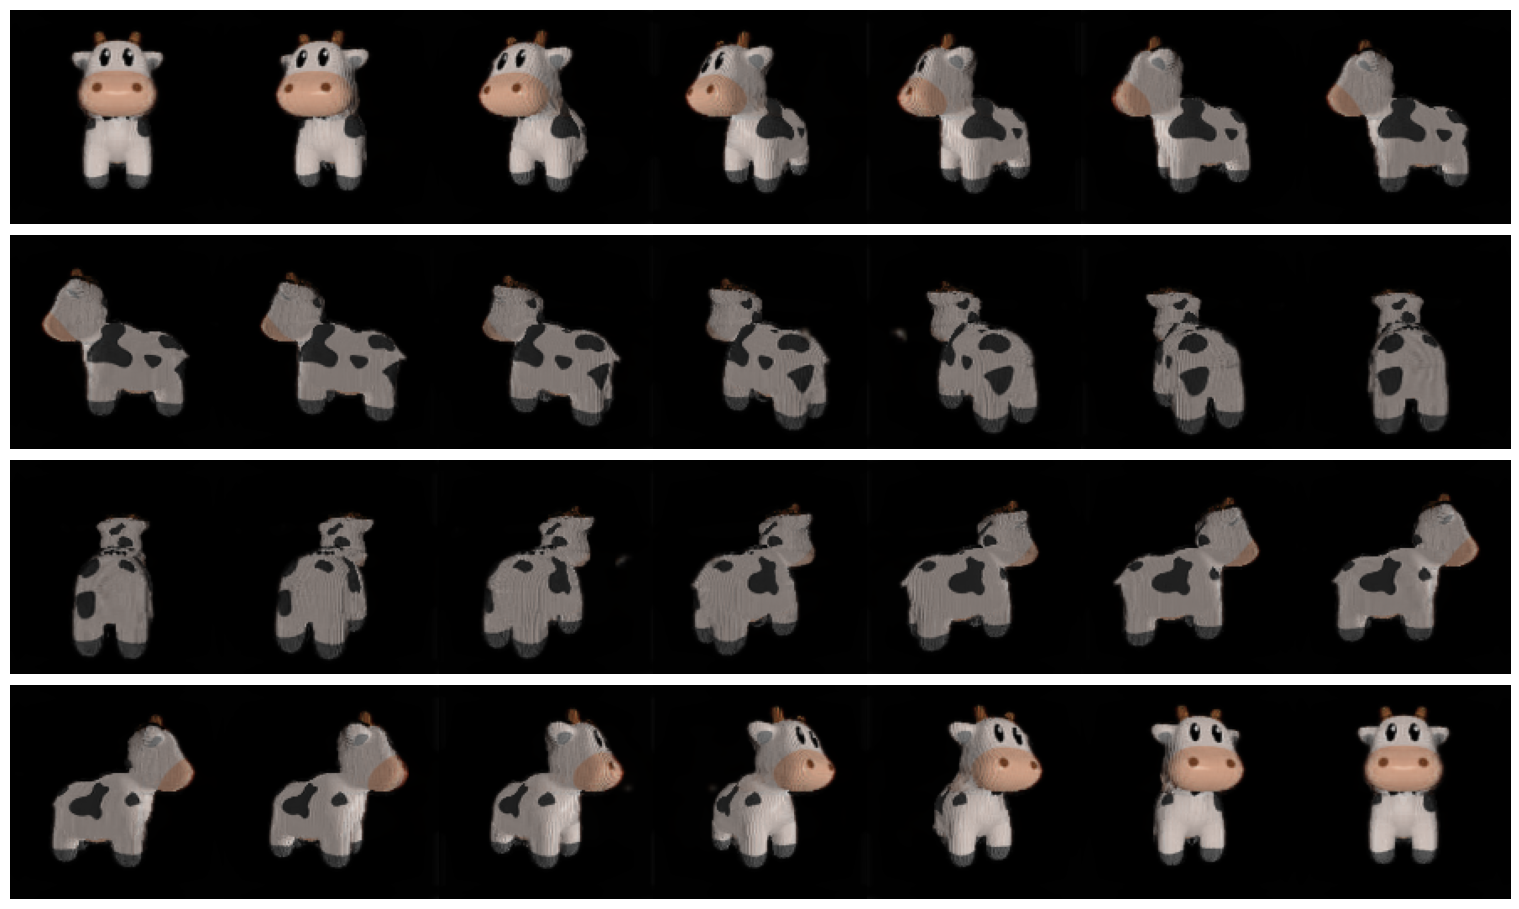

In [9]:
def generate_rotating_volume(volume_model, n_frames = 50):
    logRs = torch.zeros(n_frames, 3, device=device)
    logRs[:, 1] = torch.linspace(0.0, 2.0 * 3.14, n_frames, device=device)
    Rs = so3_exp_map(logRs)
    Ts = torch.zeros(n_frames, 3, device=device)
    Ts[:, 2] = 2.7
    frames = []
    print('Generating rotating volume ...')
    for R, T in zip(tqdm(Rs), Ts):
        camera = FoVPerspectiveCameras(
            R=R[None],
            T=T[None],
            znear = target_cameras.znear[0],
            zfar = target_cameras.zfar[0],
            aspect_ratio = target_cameras.aspect_ratio[0],
            fov = target_cameras.fov[0],
            device=device,
        )
        frames.append(volume_model(camera)[..., :3].clamp(0.0, 1.0))
    return torch.cat(frames)

with torch.no_grad():
    rotating_volume_frames = generate_rotating_volume(volume_model, n_frames=7*4)

image_grid(rotating_volume_frames.clamp(0., 1.).cpu().numpy(), rows=4, cols=7, rgb=True, fill=True)
plt.show()